# Customer Churn Prediction

In [85]:
# Importing required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
import warnings

from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


warnings.filterwarnings("ignore")
%matplotlib inline

### Read data

In [90]:
# load xlsx file

df = pd.read_excel("customer_churn_large_dataset.xlsx")

In [91]:
df.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [92]:
# checking rows and columns for the dataset

df.shape


(100000, 9)

In [93]:
# columns datatypes
df.columns

Index(['CustomerID', 'Name', 'Age', 'Gender', 'Location',
       'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB',
       'Churn'],
      dtype='object')

### Observations :-
- Here "CustomerID" and "Name" features are not required for our analysis,so remove these two columns

In [94]:
# Dropping "CustomerID" and "Name" columns

df.drop(["CustomerID","Name","Age"],axis = 1,inplace = True)

In [95]:
# DataFrame after removing above two columns
df.head(2)

,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,Male,Los Angeles,17,73.36,236,0
1,Female,New York,1,48.76,172,0


In [96]:
# defining numerical & categorical columns

numerical_features = [feature for feature in df.columns if df[feature].dtype !="O"]
categorical_features = [feature for feature in df.columns if df[feature].dtype =="O"]

# Printing numerical and categorical features
print('We have {} numerical features : {}'.format(len(numerical_features), numerical_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 4 numerical features : ['Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB', 'Churn']

We have 2 categorical features : ['Gender', 'Location']


### *Checking missing values in the DataFrame


In [97]:
df.isna().sum()

Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

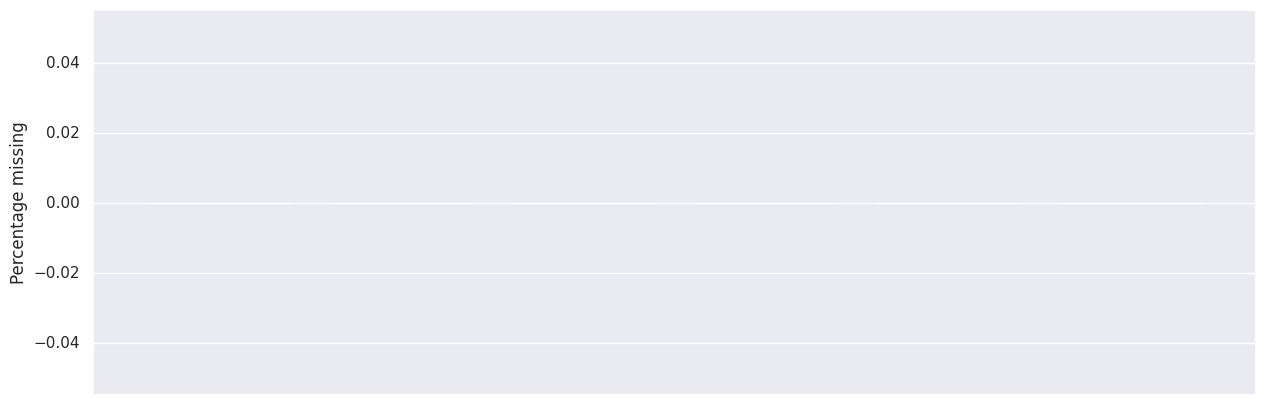

In [98]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

### Observations :-
- There are no missing values in any column ,so no need to perform any imputation operations
- Graph showing empty as there are no missing values

### *Checking duplicate values

In [99]:
df.duplicated().sum()

0

### Observations :-
- There are no duplicate values

### *Checking for outliers in the DataFrame

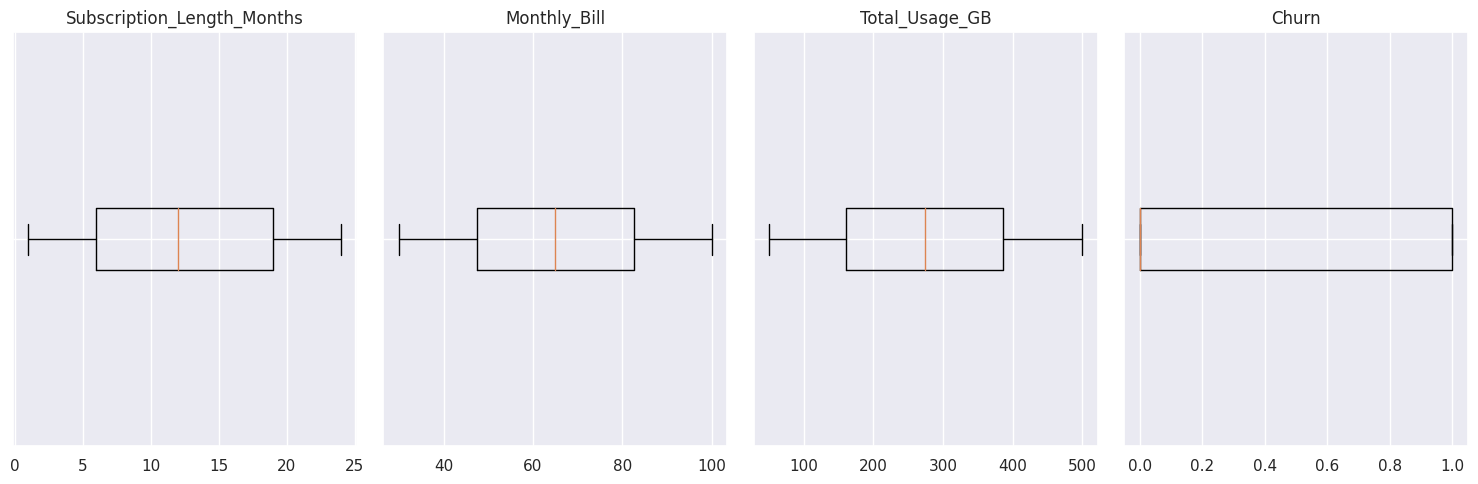

In [100]:
# Create a figure with subplots
fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5))

# Plot boxplots for each column in a subplot
for i, column in enumerate(numerical_features):
    axes[i].boxplot(df[column], vert=False)
    axes[i].set_title(column)
    axes[i].set_yticklabels([])

plt.tight_layout()
plt.show()



### Observations :-

- By above graph we can say there are no outliers

### *Checking the whether the dataset is imbalanced or not

In [101]:
df['Churn'].value_counts()

0    50221
1    49779
Name: Churn, dtype: int64

### Visualization of unique values in Target Variable

Positive: 49779, Negative: 50221


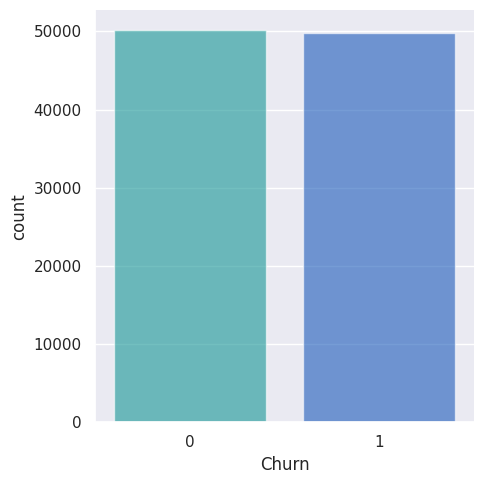

In [102]:
pos = df[df['Churn']==1].shape[0]
neg = df[df['Churn']==0].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="Churn", kind="count", palette="winter_r", alpha=.6)
plt.show()

### Observations :-

- The dataset is balanced
- No need to perform resampling

### *Checking correlation

<Axes: >

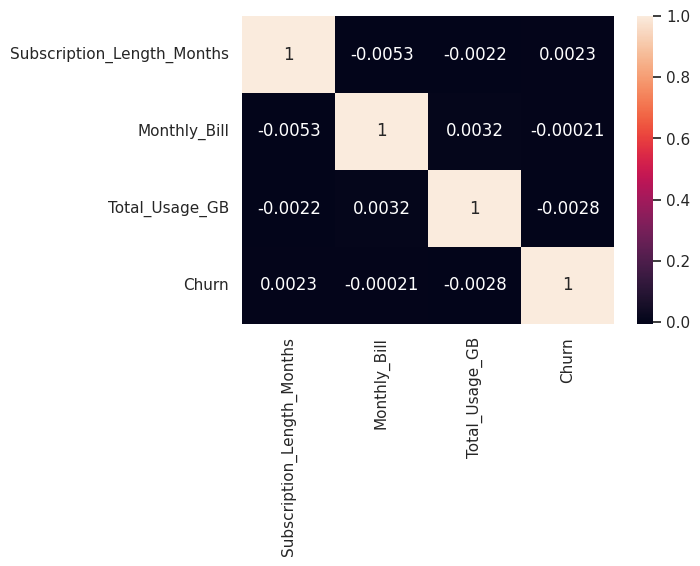

In [103]:
sns.set(rc ={'figure.figsize':(6,4) })
sns.heatmap(df.corr(),annot = True)

### Observations :-

- There is no correlation among the features

### * Checking skewness

In [104]:
df.skew()

Subscription_Length_Months   -0.001655
Monthly_Bill                 -0.000326
Total_Usage_GB                0.007113
Churn                         0.008840
dtype: float64

### Observations :-

- The features are not skewed

### Plotting Distribution of all Independent Numerical features

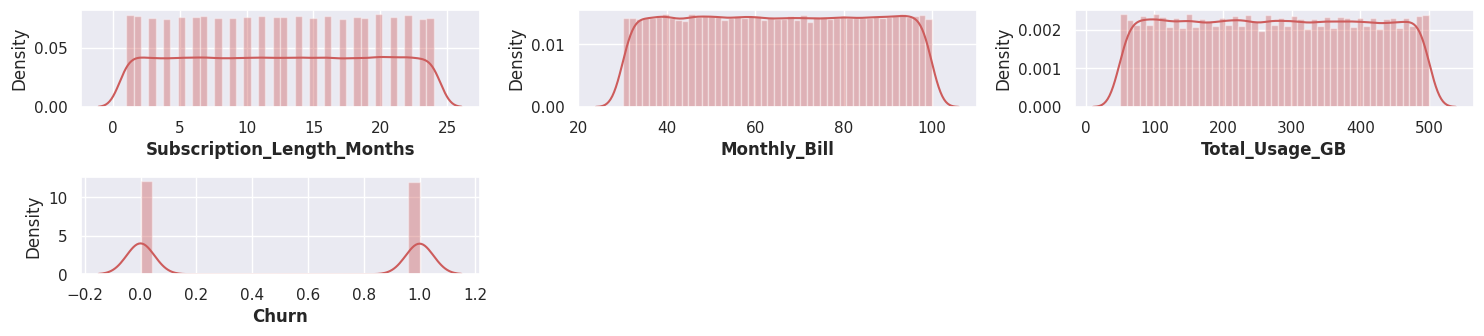

In [105]:
plt.figure(figsize=(15, 100))
for i, col in enumerate(numerical_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

### Observations :-

- features are following uniform distribution

### Performing feature transformation
- Here we have two categorical features we need to convert them into numerical values
- Both the features are nominal variables we can use get_dummies method

In [106]:
df['Location'].unique()

array(['Los Angeles', 'New York', 'Miami', 'Chicago', 'Houston'],
      dtype=object)

In [107]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [108]:
dummies = pd.get_dummies(df['Location'])
dummies

,Chicago,Houston,Los Angeles,Miami,New York
0,0,0,1,0,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
99995,0,1,0,0,0
99996,0,0,0,0,1
99997,1,0,0,0,0
99998,0,0,0,0,1


In [109]:
# now combining two dataframes
df = pd.concat([df,dummies],axis = 1)

In [110]:
df.head(2)

,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Chicago,Houston,Los Angeles,Miami,New York
0,Male,Los Angeles,17,73.36,236,0,0,0,1,0,0
1,Female,New York,1,48.76,172,0,0,0,0,0,1


In [111]:
# Dropping Location column as we created dummies for it
df.drop("Location",axis = 1,inplace = True)

In [112]:
dummies = pd.get_dummies(df["Gender"])
dummies.head()

,Female,Male
0,0,1
1,1,0
2,1,0
3,1,0
4,1,0


In [113]:
# now combining two dataframes
df = pd.concat([df,dummies],axis = 1)

In [114]:
# Dropping Location column as we created dummies for it
df.drop("Gender",axis = 1,inplace = True)

In [115]:
df.head(2)

,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Chicago,Houston,Los Angeles,Miami,New York,Female,Male
0,17,73.36,236,0,0,0,1,0,0,0,1
1,1,48.76,172,0,0,0,0,0,1,1,0


### Functions for model training and evaluation

In [116]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [117]:
# Create a function which can evaluate models and return a report
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    models_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    train_precision_list = []
    test_precision_list = []
    train_recall_list = []
    test_recall_list = []
    train_f1_score = []
    test_f1_score = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        train_accuracy_list.append(model_train_accuracy)
        test_accuracy_list.append(model_test_accuracy)
        train_precision_list.append(model_train_precision)
        test_precision_list.append(model_test_precision)
        train_recall_list.append(model_train_recall)
        test_recall_list.append(model_test_recall)
        train_f1_score.append(model_train_f1)
        test_f1_score.append(model_test_f1)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print('='*35)
        print('\n')

    report=pd.DataFrame(list(zip(models_list, train_accuracy_list,test_accuracy_list,train_precision_list,test_precision_list,train_recall_list,test_recall_list,train_f1_score,test_f1_score)), columns=['Model Name', 'Train Accuracy',"Test Accuracy","Train Precision","Test Precision","Train Recall","Test Recall","Train f1_score","Test f1_score"]).sort_values(by=["Train f1_score"])

    return report

In [118]:
# Splitting X and y

X = df.drop('Churn',axis = 1)
y = df["Churn"]

In [119]:
# Initializing different models in a dictionary

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [120]:
report  = evaluate_models(X,y,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 0.9999
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.4960
- F1 score: 0.4872
- Precision: 0.4919
- Recall: 0.4826
- Roc Auc Score: 0.4959


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 0.9999
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.5054
- F1 score: 0.5010
- Precision: 0.5015
- Recall: 0.5005
- Roc Auc Score: 0.5054


Gradient Boosting
Model performance for Training set
- Accuracy: 0.5365
- F1 score: 0.4970
- Precision: 0.5411
- Recall: 0.4596
- Roc Auc Score: 0.5363
----------------------------------
Model performance for Test set
- Accuracy: 0.5003
- F1 score: 0.4558
- Precision: 0.4957
- Recall: 0.4218
- Roc Auc Score: 0.4997


Logistic Regression
Model performance for Training 

In [121]:
report

,Model Name,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train f1_score,Test f1_score
3,Logistic Regression,0.501775,0.50395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,AdaBoost Classifier,0.514150,0.50355,0.514006,0.499547,0.455768,0.444612,0.483138,0.470482
2,Gradient Boosting,0.536525,0.50030,0.541051,0.495677,0.459632,0.421832,0.497029,0.455783
5,XGBClassifier,0.645650,0.49840,0.648264,0.494252,0.631316,0.481000,0.639678,0.487536
4,K-Neighbors Classifier,0.689213,0.50090,0.688887,0.496899,0.686035,0.492692,0.687458,0.494787
1,Decision Tree,0.999962,0.50545,1.000000,0.501515,0.999925,0.500454,0.999962,0.500984
0,Random Forest,0.999962,0.49605,0.999950,0.491884,0.999975,0.482613,0.999962,0.487204


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Feature Engineering

In [123]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [124]:
sc.fit(X_train)

StandardScaler()

In [125]:
X_train = sc.transform(X_train)

In [126]:
X_test = sc.transform(X_test)

### k nearest neighbours


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Create a KNN classifier
knn = KNeighborsClassifier()

# Define hyperparameter grid for grid search
param_grid = {
    'n_neighbors': np.arange(1, 21),  # Test k values from 1 to 20
    'weights': ['uniform', 'distance'],  # Test both uniform and distance weighting
    'p': [1, 2]  # Test both Manhattan (p=1) and Euclidean (p=2) distance metrics
}

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)


Best Hyperparameters: {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
Best Accuracy Score: 0.505025


### Logistic regression

In [46]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Define the hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
}

# Create a logistic regression model
logistic_regression = LogisticRegression(solver='liblinear')

# Create a GridSearchCV object to perform hyperparameter tuning
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data, tuning hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_score)


Best Hyperparameters:  {'C': 0.01, 'penalty': 'l1'}
Best Accuracy:  0.5026625


### XGB classifier

In [47]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score


param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
}

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_xgb = grid_search.best_estimator_

# Train the model with the best parameters
best_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test set: {accuracy}')

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)


Accuracy on the test set: 0.49975
Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}


### Decision tree

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create a Decision Tree classifier
clf = DecisionTreeClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Accuracy Score: 0.5037375000000001


### ANN

In [53]:
import tensorflow
print(tensorflow.__version__)

2.13.0


In [54]:
## importing keras libraries and packages
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [58]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(80000, 11) (80000,) (20000, 11) (20000,)


In [57]:
classifier = Sequential()

classifier.add(Dense(units = 10,kernel_initializer = "he_uniform",activation = "relu",input_dim = 11))

classifier.add(Dense(units = 10,kernel_initializer = "he_uniform",activation = "relu",))

classifier.add(Dense(units = 1,kernel_initializer = "glorot_uniform",activation = "sigmoid"))

In [59]:
classifier.compile(optimizer="adam",loss= "binary_crossentropy",metrics=["accuracy"])

In [60]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                120       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 241 (964.00 Byte)
Trainable params: 241 (964.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Observations :-
-  After training the data with different models
-  Came to a conclusion that k-Neighbors Classifier is performing well with best accuracy score of 50.50% accuracy

In [128]:
### Final Model
knc = KNeighborsClassifier(n_neighbors= 20, p= 1, weights= 'uniform')

In [129]:
knc.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=20, p=1)

In [132]:
train_pred = knc.predict(X_train)
test_pred = knc.predict(X_test)

In [133]:
print(f"Test accuracy : {accuracy_score(train_pred,y_train)}")
print(f"Test accuracy : {accuracy_score(test_pred,y_test)}")

Test accuracy : 0.5901
Test accuracy : 0.4984
